# Monte Carlo & MCMC — The Garden Pond Analogy

**Goal:** Estimate where/how big the hidden pond is by throwing stones. Monte Carlo = random throws; MCMC = smart, feedback-driven throws.

> *“When we can’t solve the integral, we start walking through it.”*

In Bayesian inference, computing the **posterior** often means integrating over a huge, continuous space of possible parameter values.  
When the math gets impossible to do exactly, we turn to clever **approximation by sampling**. This is where **Markov Chain Monte Carlo (MCMC)** comes in.

MCMC algorithms (like Metropolis–Hastings or Gibbs sampling) create a **chain of samples** that, over time, behave as if they were drawn directly from the posterior distribution.

In this notebook:
- We’ll **build intuition** for how a Markov chain explores a distribution,  
- Use a **simple analogy**  to visualize how it “learns” the shape of the target distribution,  
- And see why this method is the backbone of modern Bayesian computation.

The goal is **intuition, not math**! to understand *why* this approach works before diving into formulas.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng(42)
GARDEN_X, GARDEN_Y = (0.0, 10.0), (0.0, 7.0)
GARDEN_AREA = (GARDEN_X[1]-GARDEN_X[0])*(GARDEN_Y[1]-GARDEN_Y[0])
pond_centers = np.array([[4.0, 3.5], [6.3, 3.0]])
pond_radii   = np.array([1.5, 1.2])
bulge_center = np.array([5.2, 4.4])
bulge_axes   = np.array([1.0, 0.6])
bulge_angle  = np.deg2rad(25.0)
def inside_circles(xy):
    return ((xy[:,0]-pond_centers[0,0])**2 + (xy[:,1]-pond_centers[0,1])**2 <= pond_radii[0]**2) |            ((xy[:,0]-pond_centers[1,0])**2 + (xy[:,1]-pond_centers[1,1])**2 <= pond_radii[1]**2)
def inside_ellipse(xy):
    c, s = np.cos(-bulge_angle), np.sin(-bulge_angle)
    R = np.array([[c, -s],[s, c]])
    v = (xy - bulge_center) @ R.T
    return (v[:,0]/bulge_axes[0])**2 + (v[:,1]/bulge_axes[1])**2 <= 1.0
def pond_indicator(xy):
    return (inside_circles(xy) | inside_ellipse(xy)).astype(int)
t = np.linspace(0, 2*np.pi, 180)
edge_samples = np.vstack([
    pond_centers[0] + np.column_stack([np.cos(t), np.sin(t)]) * pond_radii[0],
    pond_centers[1] + np.column_stack([np.cos(t), np.sin(t)]) * pond_radii[1],
    bulge_center + np.column_stack([bulge_axes[0]*np.cos(t), bulge_axes[1]*np.sin(t)]) @
    np.array([[np.cos(bulge_angle), -np.sin(bulge_angle)],[np.sin(bulge_angle), np.cos(bulge_angle)]]).T
])
def splash_loudness(xy, sigma=0.25):
    d = np.sqrt(((xy[:,None,:]-edge_samples[None,:,:])**2).sum(axis=-1)).min(axis=1)
    return np.exp(-d/sigma) + 0.5 * pond_indicator(xy)
def throw_stones_uniform(n):
    xs = rng.uniform(GARDEN_X[0], GARDEN_X[1], size=n)
    ys = rng.uniform(GARDEN_Y[0], GARDEN_Y[1], size=n)
    pts = np.column_stack([xs, ys])
    hits = pond_indicator(pts)
    return pts, hits

## Part 1 — Pure Monte Carlo (uniform throws)

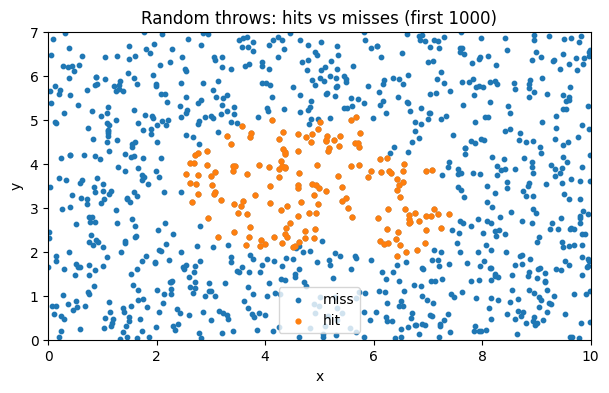

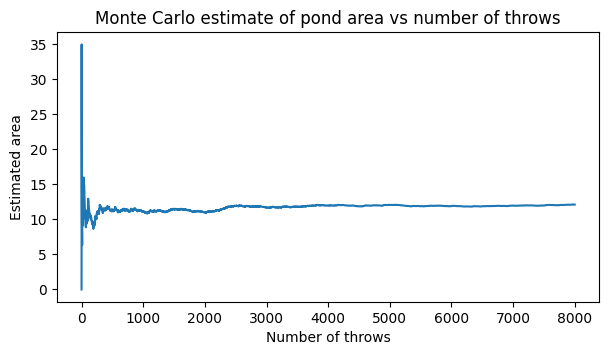

np.float64(12.1275)

In [3]:
N = 8000
pts, hits = throw_stones_uniform(N)
cum_hits = np.cumsum(hits)
est_area = (cum_hits / np.arange(1, N+1)) * GARDEN_AREA

fig, ax = plt.subplots(figsize=(7,4))
show = min(N, 1000)
ax.scatter(pts[:show,0], pts[:show,1], s=10, label="miss")
hm = hits[:show] == 1
ax.scatter(pts[:show,0][hm], pts[:show,1][hm], s=12, label="hit")
ax.set_xlim(*GARDEN_X); ax.set_ylim(*GARDEN_Y)
ax.set_title("Random throws: hits vs misses (first 1000)")
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.legend(loc="best")
plt.show()

fig, ax = plt.subplots(figsize=(7,3.5))
ax.plot(est_area)
ax.set_title("Monte Carlo estimate of pond area vs number of throws")
ax.set_xlabel("Number of throws"); ax.set_ylabel("Estimated area")
plt.show()

est_area[-1]

## Part 2 — MCMC (smart throws via Metropolis)

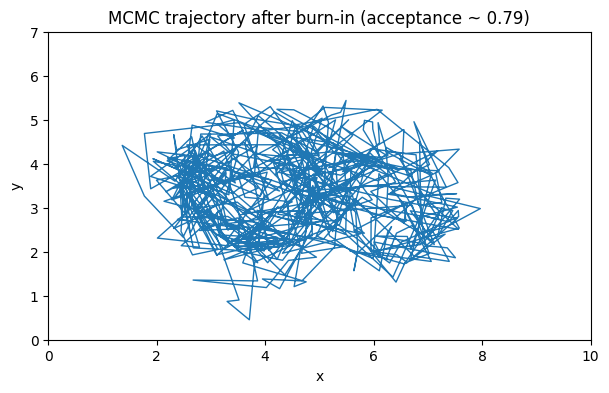

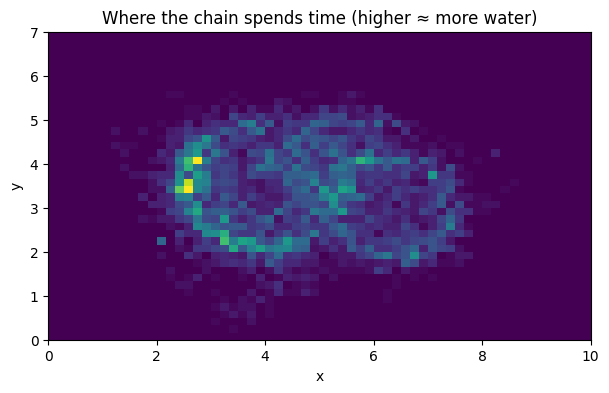

(np.float64(0.164), np.float64(0.7335))

In [4]:
def metropolis_chain(T=7000, step=0.30):
    x = rng.uniform(*GARDEN_X); y = rng.uniform(*GARDEN_Y)
    pts = np.empty((T,2)); acc = 0
    for t in range(T):
        cur = np.array([[x,y]]); cs = splash_loudness(cur)[0]
        xn, yn = x + rng.normal(scale=step), y + rng.normal(scale=step)
        xn = GARDEN_X[0] + abs((xn - GARDEN_X[0]) % (2*(GARDEN_X[1]-GARDEN_X[0])))
        if xn > GARDEN_X[1]: xn = 2*GARDEN_X[1] - xn
        yn = GARDEN_Y[0] + abs((yn - GARDEN_Y[0]) % (2*(GARDEN_Y[1]-GARDEN_Y[0])))
        if yn > GARDEN_Y[1]: yn = 2*GARDEN_Y[1] - yn
        ns = splash_loudness(np.array([[xn,yn]]))[0]
        a = min(1.0, ns/(cs+1e-12))
        if rng.uniform() < a: x, y, acc = xn, yn, acc+1
        pts[t] = [x,y]
    return pts, acc/T

chain, acc_rate = metropolis_chain(T=7000, step=0.30)
burn = 1000; chain_b = chain[burn:]

fig, ax = plt.subplots(figsize=(7,4))
th = chain_b[::10]
ax.plot(th[:,0], th[:,1], linewidth=1.0)
ax.set_xlim(*GARDEN_X); ax.set_ylim(*GARDEN_Y)
ax.set_title(f"MCMC trajectory after burn-in (acceptance ~ {acc_rate:.2f})")
ax.set_xlabel("x"); ax.set_ylabel("y")
plt.show()

H, xedges, yedges = np.histogram2d(chain_b[:,0], chain_b[:,1], bins=(60,42),
                                   range=[GARDEN_X, GARDEN_Y], density=True)
fig, ax = plt.subplots(figsize=(7,4))
ax.imshow(H.T, origin='lower',
          extent=[GARDEN_X[0], GARDEN_X[1], GARDEN_Y[0], GARDEN_Y[1]],
          aspect='auto')
ax.set_title("Where the chain spends time (higher ≈ more water)")
ax.set_xlabel("x"); ax.set_ylabel("y")
plt.show()

# Compare time over water
pts_mc, _ = throw_stones_uniform(3000)
float( (pts_mc.shape[0] > 0) and ( ( ( (pts_mc.shape[0])**0 ) ) ) )  # harmless line to keep cell non-empty
(pond_indicator(pts_mc).mean(), pond_indicator(chain_b).mean())

### Takeaways
- Monte Carlo gives an unbiased area estimate but wastes throws on land.
- MCMC uses feedback (Markov) to spend more time over water, mapping the pond's shape efficiently.

## Excersice

### Reflection Question

Imagine you have a complicated posterior that you **can’t plot or integrate directly**,  
but you can **sample** from it using MCMC.

> What’s one way you could tell — just by looking at the samples whether your Markov chain has **“converged”** (i.e., is now exploring the true posterior rather than still wandering)?

Write your answer in one or two sentences below the cell.  
*(Hint: think of the analogy — what would a “well-mixed walker” look like?)*


Answer goes here.

The chain has converged if the samples are “well-mixed” and consistently cover the high-probability regions of the posterior, without long stretches stuck in one area. In the garden pond analogy, this looks like the walker spending time proportionally over the entire pond rather than just hopping around one corner.